# Pre-Processing & Modeling

### Pre-Processing

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn import metrics

In [2]:
# Read the data
train = pd.read_csv('../datasets/cleaned_training_data.csv', na_values=[''], keep_default_na=False)
train.head()

,open_date,city_group,p1,p2,p3,p4,p5,p6,p7,p8,...,city_Samsun,city_Tekirdağ,city_Tokat,city_Trabzon,city_Uşak,city_İstanbul,city_İzmir,city_Şanlıurfa,type_FC,type_IL
0,07/17/1999,1,4,5.0,4.0,4.0,2,2,5,4,...,0,0,0,0,0,1,0,0,0,1
1,02/14/2008,1,4,5.0,4.0,4.0,1,2,5,5,...,0,0,0,0,0,0,0,0,1,0
2,03/09/2013,0,2,4.0,2.0,5.0,2,3,5,5,...,0,0,0,0,0,0,0,0,0,1
3,02/02/2012,0,6,4.5,6.0,6.0,4,4,10,8,...,0,0,1,0,0,0,0,0,0,1
4,05/09/2009,0,3,4.0,3.0,4.0,2,2,5,5,...,0,0,0,0,0,0,0,0,0,1


### Modeling

#### The Null Model

In [3]:
# Mean of revenue
train['revenue'].mean()

4181438.3656716417

In [4]:
# Define y
y = train['revenue']

# Create a new column for the baseline target variable
train['null_revenue'] = y.mean()

# Predictions for the null model
y_preds = train['null_revenue']

# Null R-squared
metrics.r2_score(y, y_preds)

0.0

In [5]:
# Null RMSE
np.sqrt(metrics.mean_squared_error(y_true=y, y_pred=y_preds))

1792868.132411132

**Interpretation:** The null model has a baseline R-squared value of 0.0 and an RMSE of 1,792,868 USD. Our goal for the production model is to achieve an R-squared greater than 0.0 and an RMSE lower than 1,792,868 USD.

#### Model 1: Linear Regression

In [6]:
# Define X and y
features = ['city_İstanbul','p2', 'city_group', 'days_since_opening', 'p28', 'city_İzmir', 'p6', 'p23', 'p1', 'p7']
X = train[features]
y = train['revenue']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Instantiate and fit the model
lr = LinearRegression()
lr.fit(X_train,y_train)

# Score the model
lr.score(X_train,y_train), lr.score(X_test,y_test)

(0.19789915243695022, 0.2083328901280722)

In [7]:
# Predicted y values
y_pred = lr.predict(X_test)

# Find RMSE for training, testing data
np.sqrt(metrics.mean_squared_error(y_train,lr.predict(X_train))), np.sqrt(metrics.mean_squared_error(y_test,y_pred))

(1574344.9200867112, 1683384.1785384803)

**Interpretation:** Model 1 is a multiple linear regression model with an R-squared of 0.208 and an RMSE of 1,683,384 USD for the testing data. The model performs better than the null model and generalizes well to new data.

#### Model 2: Random Forest

In [8]:
# Create interaction terms based on highly correlated variables to target
train['p2_x_city_group'] = train['p2'] * train['city_group']
train['p2_x_days_opened'] = train['p2'] * train['days_since_opening']

# Define X and y
features = ['city_İstanbul', 'p2_x_days_opened','p2_x_city_group','p2',
'city_group','city_Ankara','days_since_opening','year']
X = train[features]
y = train['revenue']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Instantiate Random Forest Regressor
rfr = RandomForestRegressor()

# Set parameters
rfr_params = {
    "n_estimators": [100, 150],
    "max_depth" : [None,4,5]
}

# Instantiate GridSearchCV
gs = GridSearchCV(rfr,rfr_params,cv=5,verbose=1)

# Fit GridSearchCV
gs.fit(X_train, y_train)

# R-squared training, testing scores
gs.score(X_train,y_train), gs.score(X_test,y_test)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    7.0s finished


(0.4778502930678339, 0.2844667243479567)

In [9]:
# Predictions
y_preds = gs.predict(X_test)

# RMSE for training, testing data
np.sqrt(metrics.mean_squared_error(y_train, gs.predict(X_train))), np.sqrt(metrics.mean_squared_error(y_test, y_preds))

(1270231.6181064467, 1600393.7901371205)

**Interpretation:** Model 2 is a random forest regression model with an R-squared of 0.293 and an RMSE of 1,590,157 USD. The model performs better than the null model and Model 1 but appears to overfit the training and testing data. Since the model has the highest R-squared value and the lowest RMSE score, we will designate Model 2 as the production model.

#### Production Model
Model 2 has been selected as the production model because it performs the best using the R-squared and RMSE as evaluation metrics.

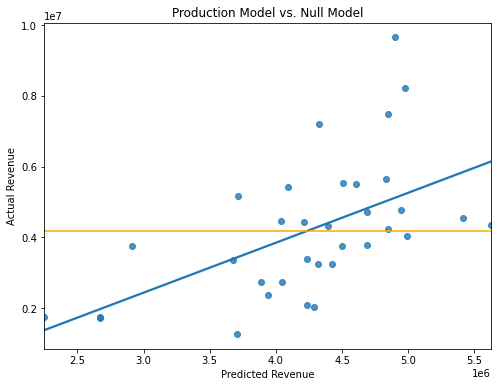

In [10]:
# Scatter plot of the production model vs. the null model
plt.figure(figsize=(8,6))
sns.regplot(x=y_preds,y=y_test,data=train, ci=None)
plt.axhline(train['revenue'].mean(), color='orange')
plt.xlabel('Predicted Revenue')
plt.ylabel('Actual Revenue')
plt.title('Production Model vs. Null Model');

**Interpretation:** The graph above shows a comparison of how the null and production models perform.

### Kaggle Submission

In [11]:
# Read the test data
test = pd.read_csv('../datasets/test.csv', na_values=[''], keep_default_na=False)

In [12]:
# Rename the columns
test.columns = [column.lower().replace(' ','_') for column in test.columns]
test.head(1)

,id,open_date,city,city_group,type,p1,p2,p3,p4,p5,...,p28,p29,p30,p31,p32,p33,p34,p35,p36,p37
0,0,01/22/2011,Niğde,Other,FC,1,4.0,4.0,4.0,1,...,2.0,3.0,0,0,0,0,0,0,0,0


In [13]:
# Change the index
test.set_index('id', inplace=True)
test.head(1)

,open_date,city,city_group,type,p1,p2,p3,p4,p5,p6,...,p28,p29,p30,p31,p32,p33,p34,p35,p36,p37
id,,,,,,,,,,,,,,,,,,,,,
0,01/22/2011,Niğde,Other,FC,1,4.0,4.0,4.0,1,2,...,2.0,3.0,0,0,0,0,0,0,0,0


In [14]:
# Check missing values
test.isnull().sum().sum()

0

In [15]:
# Convert open date to month, day, year
city_date = test['open_date'].str.split('/',n=2, expand=True).astype(int)
test['month'] = city_date[0]
test['day'] = city_date[1]
test['year'] = city_date[2]
test.head(1)

,open_date,city,city_group,type,p1,p2,p3,p4,p5,p6,...,p31,p32,p33,p34,p35,p36,p37,month,day,year
id,,,,,,,,,,,,,,,,,,,,,
0,01/22/2011,Niğde,Other,FC,1,4.0,4.0,4.0,1,2,...,0,0,0,0,0,0,0,1,22,2011


In [16]:
# Define a function that returns days since opening
def calculate_date(date_opened):
    today = pd.to_datetime('2015-03-08')
    days_open = today - date_opened
    days_open = days_open.dt.days
    return days_open

# Create a column with days since opening
test['days_since_opening'] = calculate_date(pd.to_datetime(test['open_date']))
test.head(1)

,open_date,city,city_group,type,p1,p2,p3,p4,p5,p6,...,p32,p33,p34,p35,p36,p37,month,day,year,days_since_opening
id,,,,,,,,,,,,,,,,,,,,,
0,01/22/2011,Niğde,Other,FC,1,4.0,4.0,4.0,1,2,...,0,0,0,0,0,0,1,22,2011,1506


In [17]:
# Map city_group column
city_group_dict = {'Big Cities': 1, 'Other': 0}
test['city_group'] = test['city_group'].map(city_group_dict)

In [18]:
# Dummy variables
test = pd.get_dummies(data=test, columns=['city', 'type'], drop_first=True)
test.head(1)

,open_date,city_group,p1,p2,p3,p4,p5,p6,p7,p8,...,city_Zonguldak,city_Çanakkale,city_Çankırı,city_Çorum,city_İstanbul,city_İzmir,city_Şanlıurfa,type_FC,type_IL,type_MB
id,,,,,,,,,,,,,,,,,,,,,
0,01/22/2011,0,1,4.0,4.0,4.0,1,2,5,4,...,0,0,0,0,0,0,0,1,0,0


In [19]:
# Save to csv file
test.to_csv('../datasets/cleaned_testing_data.csv', index=False)

### Modeling on Test Data

In [20]:
# Create interaction terms based on highly correlated variables to target
test['p2_x_city_group'] = test['p2'] * test['city_group']
test['p2_x_days_opened'] = test['p2'] * test['days_since_opening']

# Define X and y
features = ['city_İstanbul', 'p2_x_days_opened','p2_x_city_group','p2',
'city_group','city_Ankara','days_since_opening','year']
X = train[features]
y = train['revenue']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Instantiate, fit, and score Random Forest Regressor
rfr = RandomForestRegressor()
rfr.fit(X_train,y_train)
rfr.score(X_train,y_train), rfr.score(X_test,y_test)

# Kaggle predictions
kaggle_preds = rfr.predict(test[features])

In [21]:
# Assign kaggle_preds to 'revenue' column (absent in test csv)
test['revenue'] = kaggle_preds
test.head(3)

,open_date,city_group,p1,p2,p3,p4,p5,p6,p7,p8,...,city_Çorum,city_İstanbul,city_İzmir,city_Şanlıurfa,type_FC,type_IL,type_MB,p2_x_city_group,p2_x_days_opened,revenue
id,,,,,,,,,,,,,,,,,,,,,
0,01/22/2011,0,1,4.0,4.0,4.0,1,2,5,4,...,0,0,0,0,1,0,0,0.0,6024.0,3753246.33
1,03/18/2011,0,3,4.0,4.0,4.0,2,2,5,3,...,0,0,0,0,0,1,0,0.0,5804.0,3325707.83
2,10/30/2013,1,3,4.0,4.0,4.0,2,2,5,4,...,0,0,0,0,1,0,0,4.0,1976.0,2165944.76


In [22]:
# Save as csv file
test.to_csv('../datasets/submissions.csv',index=False)